- Zero-shot classification instead of keywords + scibert
- Increased max token length from 256 → 512 to reduce information loss.
- Switched to softer text cleaning to preserve punctuation and technical terms. 


Result: With a threshold as low as 0.5, still many abstracts are unlabeled (false in every column)

## Setup

In [4]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [5]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [6]:
# Constants

CREATE_ABSTRACTS_DATASET = False

#### Create Abstracts dataset (only need to do this once)

In [ ]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [8]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [9]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 32714 abstracts


In [10]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [11]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [12]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False


In [13]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False,"[supervised, unsupervised]"
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,"[supervised, unsupervised]"
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,"[supervised, unsupervised]"
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,True,True,False,"[supervised, unsupervised]"
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,False,True,False,[unsupervised]


In [14]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          18854
supervised       10198
unsupervised      3945
reinforcement     2096
Name: count, dtype: int64

In [15]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,30,293,69,594
ml_automation,126,321,1138,150
ml_defect_detection,23,297,322,122
ml_manufacturing_optimization,330,1106,2399,307
ml_planning_production,252,784,1218,198
ml_plm,9,75,166,14
ml_predictive_maintenance,193,1571,2307,746
ml_process_control,221,1002,1867,363
ml_process_modeling,43,192,492,66


In [16]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.311732
is_unsupervised     0.120591
is_reinforcement    0.064070
dtype: float64

<Axes: xlabel='ml_type'>

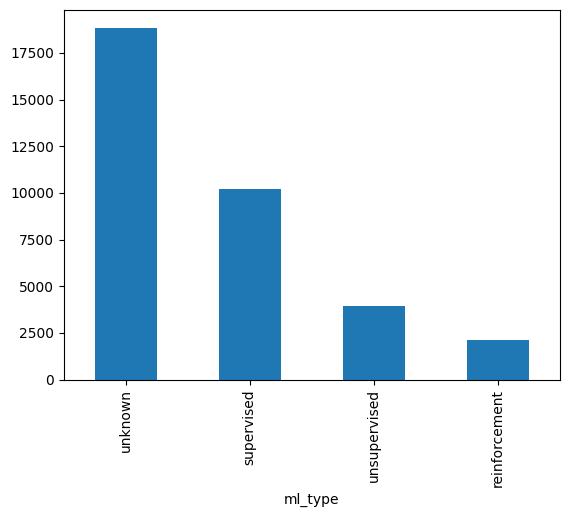

In [17]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [18]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
16494,ml_process_control,2-s2.0-85072857566,10.1007/978-3-030-24570-2_7,Uncertainties in microgrids,© Springer Nature Switzerland AG 2020.Uncertai...,© Springer Nature Switzerland AG 2020.Uncertai...,False,False,False,[unknown]
20197,ml_product_development,2-s2.0-85205982017,10.1115/DMD2024-1064,MEDICAL PRODUCT DEVELOPMENT COMPETENCIES FOR B...,© 2024 by ASME.A survey of the competencies ne...,© 2024 by ASME.A survey of the competencies ne...,False,False,False,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Zero-Shot classification

In [ ]:
from transformers import pipeline
zs_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


In [22]:
# Zero-shot candidate labels
candidate_labels = ["supervised learning", "unsupervised learning", "reinforcement learning"]


In [ ]:
# Run zero-shot classification in batches over all abstracts
def zeroshot_predict_all(df, classifier, labels, batch_size=16):
    all_scores = []
    texts = df["abstract"].tolist()
    # tqdm: progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Zero-shot batches"):
        batch_texts = texts[i:i + batch_size]
        results = classifier(batch_texts, candidate_labels=labels, multi_label=True)
        if isinstance(results, dict):  # single input case
            results = [results]
        for res in results:
            scores = {lbl: score for lbl, score in zip(res["labels"], res["scores"])}
            all_scores.append(scores)
    return all_scores

In [29]:
# Get zero-shot scores for each abstract
zs_scores = zeroshot_predict_all(df, zs_classifier, candidate_labels, batch_size=16)

Zero-shot batches: 100%|██████████| 2045/2045 [39:02<00:00,  1.15s/it]


In [30]:
# Convert zero-shot scores to binary labels with a threshold
threshold = 0.5  # can be tuned later

df["zs_is_supervised"] = [scores.get("supervised learning", 0.0) >= threshold for scores in zs_scores]
df["zs_is_unsupervised"] = [scores.get("unsupervised learning", 0.0) >= threshold for scores in zs_scores]
df["zs_is_reinforcement"] = [scores.get("reinforcement learning", 0.0) >= threshold for scores in zs_scores]


In [31]:
# Store raw zero-shot scores for later analysis
df["zs_supervised_score"] = [scores.get("supervised learning", 0.0) for scores in zs_scores]
df["zs_unsupervised_score"] = [scores.get("unsupervised learning", 0.0) for scores in zs_scores]
df["zs_reinforcement_score"] = [scores.get("reinforcement learning", 0.0) for scores in zs_scores]


In [32]:
# Build a multi-label view based on zero-shot labels
def resolve_zs_label(row):
    labels = []
    if row["zs_is_supervised"]: labels.append("supervised")
    if row["zs_is_unsupervised"]: labels.append("unsupervised")
    if row["zs_is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type_zs"] = df.apply(resolve_zs_label, axis=1)


In [34]:
# Save predictions

zero_shot_path = processed_abstracts_path / "zero_shot"
zero_shot_path.mkdir(parents=True, exist_ok=True)

save_path = zero_shot_path / "abstracts_with_predictions.csv"

df.to_csv(save_path)
print(f"saved to {save_path}")


saved to ../../data/processed/abstracts/zero_shot/abstracts_with_predictions.csv


## Analyze Zero-Shot Predictions

In [41]:
pred_path = Path("../../data/processed/abstracts/zero_shot/abstracts_with_predictions.csv")

pred_cols = ["zs_is_supervised","zs_is_unsupervised","zs_is_reinforcement"]
label_cols = ["is_supervised","is_unsupervised","is_reinforcement"]

In [36]:
df = pd.read_csv(pred_path)
df.head()

,Unnamed: 0,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type,zs_is_supervised,zs_is_unsupervised,zs_is_reinforcement,zs_supervised_score,zs_unsupervised_score,zs_reinforcement_score,ml_type_zs
0,0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False,"['supervised', 'unsupervised']",False,False,False,0.013515,0.077122,0.097537,['unknown']
1,1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,"['supervised', 'unsupervised']",False,True,False,0.014984,0.963052,0.235205,['unsupervised']
2,2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,"['supervised', 'unsupervised']",False,False,False,0.334768,0.013961,0.064352,['unknown']
3,3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,True,True,False,"['supervised', 'unsupervised']",True,False,True,0.764746,0.365491,0.568147,"['supervised', 'reinforcement']"
4,4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,False,True,False,['unsupervised'],True,False,False,0.556657,0.158409,0.481203,['supervised']


In [37]:
df[pred_cols].mean()

zs_is_supervised       0.468118
zs_is_unsupervised     0.055970
zs_is_reinforcement    0.187748
dtype: float64

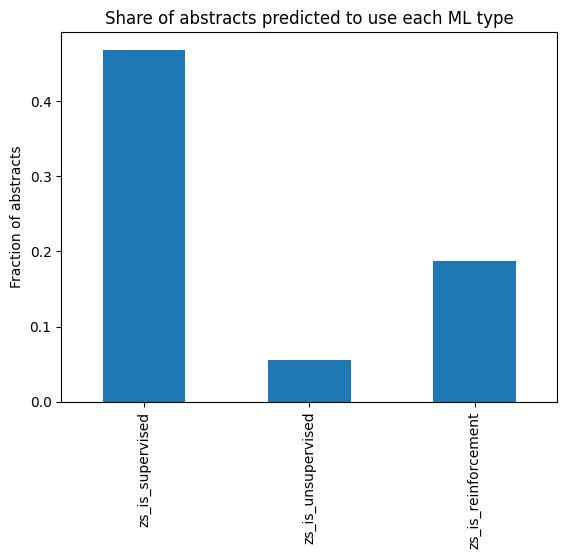

In [38]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

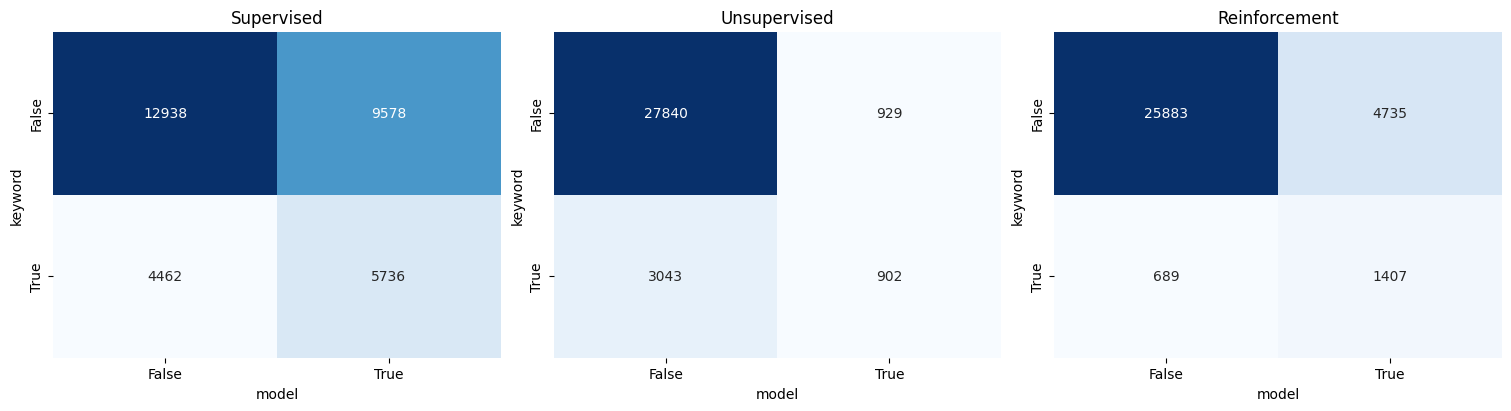

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"zs_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [44]:
# Small per-label stats
for col in label_cols:
    pred = df[f"zs_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 5736
FP: 9578
FN: 4462
TN: 12938
Precision: 0.375
Recall:    0.562


=== is_unsupervised ===
TP: 902
FP: 929
FN: 3043
TN: 27840
Precision: 0.493
Recall:    0.229


=== is_reinforcement ===
TP: 1407
FP: 4735
FN: 689
TN: 25883
Precision: 0.229
Recall:    0.671



In [47]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"zs_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"zs_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,zs_is_supervised,zs_is_unsupervised,zs_is_reinforcement
28966,10.1016/j.jmapro.2021.12.041,In-situ layer-wise certification for direct la...,© 2022 The Society of Manufacturing EngineersI...,False,True,False,False,False,False
14989,10.1016/B978-0-443-18464-2.00014-5,Machine learning techniques for sustainable in...,"© 2024 by Elsevier Inc. All rights reserved, i...",False,True,False,False,False,False
32153,10.1201/9781032694375-6,Leveraging Artificial Intelligence and Machine...,"© 2025 Taylor and Francis Group, LLC.Smart man...",False,True,False,True,False,True
24906,10.1016/j.jobe.2023.106595,A novel hybrid adaptive boosting approach for ...,© 2023Ensemble learning (EL) has gained popula...,True,False,False,True,False,True
30107,10.1007/978-3-030-11292-9_10,Blood gas predictions for patients under artif...,© Springer Nature Switzerland AG 2020.This pap...,False,True,False,True,False,False
27018,10.1016/j.ecolmodel.2020.109310,A Production–Living–Ecological Space Model for...,© 2020 Elsevier B.V.The study of production–li...,False,False,True,False,False,False
18052,10.24136/oc.3596,Immersive collaborative business process and e...,© Instytut Badań Gospodarczych /Institute of E...,False,False,True,True,True,True
16899,10.1109/ECC.2015.7330913,Safe and robust learning control with Gaussian...,© 2015 EUCA.This paper introduces a learning-b...,True,False,False,False,False,False
30243,10.1016/j.ress.2025.111394,Adaptive real-time scheduling for production a...,© 2025 Elsevier LtdProduction scheduling and m...,False,False,True,True,False,True
1522,10.1109/JIOT.2021.3050441,IoT and Fog-Computing-Based Predictive Mainten...,© 2014 IEEE.The assets in Industry 4.0 are cat...,True,False,False,False,False,False


In [49]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"zs_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
zs_is_supervised       7217
zs_is_unsupervised     1217
zs_is_reinforcement    3482
dtype: int64

=== Predictions on NON-TRAINED rows ===
zs_is_supervised       8097
zs_is_unsupervised      614
zs_is_reinforcement    2660
dtype: int64
